# Cross-Node Analysis: IDC Cases in Other CRDC Nodes

For subjects with imaging data in IDC, what other data exists across CRDC?

**Approach:** Use CDA's `upstream_id` wildcard queries to efficiently find which CRDC nodes (GDC, PDC, CDS) have data for subjects in each IDC collection. Focus on TCGA and CPTAC collections where cross-node data is most likely.

In [1]:
from idc_index import IDCClient
from cdapython import get_subject_data, get_file_data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time

pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)

idc = IDCClient()
print(f"IDC version: {idc.get_idc_version()}")

data_dir = Path('../data')
data_dir.mkdir(exist_ok=True)

IDC version: v23


## 1. IDC Collections with Cross-Node Potential

Identify collections from TCGA and CPTAC programs.

In [2]:
# Get all candidate collections with patient counts
candidates = idc.sql_query("""
    SELECT
        collection_id,
        CASE
            WHEN collection_id LIKE 'tcga_%' THEN 'TCGA'
            WHEN collection_id LIKE 'cptac_%' THEN 'CPTAC'
        END as program,
        COUNT(DISTINCT PatientID) as idc_patients,
        STRING_AGG(DISTINCT Modality, ', ') as modalities
    FROM index
    WHERE collection_id LIKE 'tcga_%' OR collection_id LIKE 'cptac_%'
    GROUP BY collection_id
    ORDER BY program, idc_patients DESC
""")

print(f"TCGA collections: {len(candidates[candidates['program'] == 'TCGA'])}")
print(f"CPTAC collections: {len(candidates[candidates['program'] == 'CPTAC'])}")
candidates

TCGA collections: 32
CPTAC collections: 13


,collection_id,program,idc_patients,modalities
0,cptac_ucec,CPTAC,254,"RTSTRUCT, US, MR, PT, SM, CT"
1,cptac_luad,CPTAC,244,"CT, SM, PT, MR"
2,cptac_ccrcc,CPTAC,233,"CT, SM, SEG, MR, RTSTRUCT"
3,cptac_lscc,CPTAC,212,"SM, CT, PT"
4,cptac_brca,CPTAC,198,SM
5,cptac_pda,CPTAC,195,"CT, SM, MR, RTSTRUCT, US, PT"
6,cptac_gbm,CPTAC,178,SM
7,cptac_coad,CPTAC,178,SM
8,cptac_hnscc,CPTAC,112,SM
9,cptac_cm,CPTAC,95,"MR, PT, SM, CT"


## 2. Cross-Node Data Availability per Collection

For each collection, query CDA to determine what fraction of IDC subjects also have data in GDC and/or PDC.

**Strategy:** Use wildcard queries on `upstream_id` to match patient ID prefixes per collection. For TCGA, the PatientID prefix pattern is `TCGA-XX-*` where `XX` is the TSS code. For CPTAC, we query individual patients in batches.

In [3]:
def get_cda_data_sources(patient_ids):
    """Query CDA for a list of patient IDs (single batch) and return their data sources."""
    filters = [f'upstream_id = {pid}' for pid in patient_ids]
    
    try:
        result = get_subject_data(match_any=filters)
        if result is not None and len(result) > 0:
            return result
    except Exception as e:
        print(f"  Error: {e}")
    
    return pd.DataFrame()

In [4]:
# Query CDA for each collection
# Sample 10 patients per collection — one CDA API call each
SAMPLE_SIZE = 10

collection_results = []

for _, row in candidates.iterrows():
    cid = row['collection_id']
    program = row['program']
    total_patients = row['idc_patients']
    
    # Get patient IDs for this collection
    patients = idc.sql_query(f"""
        SELECT DISTINCT PatientID FROM index
        WHERE collection_id = '{cid}'
        ORDER BY PatientID
        LIMIT {SAMPLE_SIZE}
    """)
    sample_ids = patients['PatientID'].tolist()
    
    print(f"{cid} ({program}): {total_patients} patients, sampling {len(sample_ids)} ... ", end="")
    
    cda_result = get_cda_data_sources(sample_ids)
    
    if len(cda_result) > 0:
        has_gdc = cda_result['data_source'].apply(lambda x: 'GDC' in x if isinstance(x, list) else False).sum()
        has_pdc = cda_result['data_source'].apply(lambda x: 'PDC' in x if isinstance(x, list) else False).sum()
        has_idc = cda_result['data_source'].apply(lambda x: 'IDC' in x if isinstance(x, list) else False).sum()
        found = len(cda_result)
    else:
        has_gdc = has_pdc = has_idc = found = 0
    
    collection_results.append({
        'collection_id': cid,
        'program': program,
        'idc_patients': total_patients,
        'sampled': len(sample_ids),
        'found_in_cda': found,
        'has_GDC': has_gdc,
        'has_PDC': has_pdc,
        'has_IDC': has_idc,
        'modalities': row['modalities']
    })
    
    print(f"CDA: {found}/{len(sample_ids)}, GDC: {has_gdc}, PDC: {has_pdc}")

cross_node_df = pd.DataFrame(collection_results)
cross_node_df

cptac_ucec (CPTAC): 254 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 10
cptac_luad (CPTAC): 244 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 10
cptac_ccrcc (CPTAC): 233 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 10
cptac_lscc (CPTAC): 212 patients, sampling 10 ... 

CDA: 10/10, GDC: 9, PDC: 9
cptac_brca (CPTAC): 198 patients, sampling 10 ... 

CDA: 10/10, GDC: 4, PDC: 4
cptac_pda (CPTAC): 195 patients, sampling 10 ... 

CDA: 10/10, GDC: 9, PDC: 10
cptac_gbm (CPTAC): 178 patients, sampling 10 ... 

CDA: 10/10, GDC: 2, PDC: 2
cptac_coad (CPTAC): 178 patients, sampling 10 ... 

CDA: 10/10, GDC: 7, PDC: 7
cptac_hnscc (CPTAC): 112 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 10
cptac_cm (CPTAC): 95 patients, sampling 10 ... 

CDA: 10/10, GDC: 0, PDC: 0
cptac_aml (CPTAC): 91 patients, sampling 10 ... 

CDA: 10/10, GDC: 8, PDC: 0
cptac_sar (CPTAC): 88 patients, sampling 10 ... 

CDA: 10/10, GDC: 0, PDC: 0
cptac_ov (CPTAC): 73 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 9
tcga_brca (TCGA): 1098 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 0


tcga_gbm (TCGA): 607 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 0
tcga_ov (TCGA): 591 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 0
tcga_ucec (TCGA): 560 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 0
tcga_luad (TCGA): 560 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 0
tcga_kirc (TCGA): 537 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 0
tcga_hnsc (TCGA): 523 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 0
tcga_lgg (TCGA): 516 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 0
tcga_thca (TCGA): 507 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 0
tcga_lusc (TCGA): 504 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 0
tcga_prad (TCGA): 500 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 0
tcga_skcm (TCGA): 470 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 0
tcga_coad (TCGA): 464 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 0
tcga_stad (TCGA): 443 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 0
tcga_blca (TCGA): 412 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 0
tcga_lihc (TCGA): 377 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 0
tcga_cesc (TCGA): 307 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 0
tcga_kirp (TCGA): 291 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 0
tcga_sarc (TCGA): 261 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 0
tcga_esca (TCGA): 185 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 0
tcga_paad (TCGA): 185 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 0
tcga_pcpg (TCGA): 179 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 0
tcga_read (TCGA): 171 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 4
tcga_tgct (TCGA): 150 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 0
tcga_thym (TCGA): 124 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 0
tcga_kich (TCGA): 113 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 0
tcga_acc (TCGA): 92 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 0
tcga_meso (TCGA): 87 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 0
tcga_uvm (TCGA): 80 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 0
tcga_ucs (TCGA): 57 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 0
tcga_chol (TCGA): 51 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 0
tcga_dlbc (TCGA): 48 patients, sampling 10 ... 

CDA: 10/10, GDC: 10, PDC: 0


,collection_id,program,idc_patients,sampled,found_in_cda,has_GDC,has_PDC,has_IDC,modalities
0,cptac_ucec,CPTAC,254,10,10,10,10,10,"RTSTRUCT, US, MR, PT, SM, CT"
1,cptac_luad,CPTAC,244,10,10,10,10,10,"CT, SM, PT, MR"
2,cptac_ccrcc,CPTAC,233,10,10,10,10,10,"CT, SM, SEG, MR, RTSTRUCT"
3,cptac_lscc,CPTAC,212,10,10,9,9,10,"SM, CT, PT"
4,cptac_brca,CPTAC,198,10,10,4,4,10,SM
5,cptac_pda,CPTAC,195,10,10,9,10,10,"CT, SM, MR, RTSTRUCT, US, PT"
6,cptac_gbm,CPTAC,178,10,10,2,2,10,SM
7,cptac_coad,CPTAC,178,10,10,7,7,10,SM
8,cptac_hnscc,CPTAC,112,10,10,10,10,10,SM
9,cptac_cm,CPTAC,95,10,10,0,0,10,"MR, PT, SM, CT"


In [5]:
# Calculate percentages (based on sampled patients)
cross_node_df['pct_in_cda'] = (cross_node_df['found_in_cda'] / cross_node_df['sampled'] * 100).round(1)
cross_node_df['pct_GDC'] = (cross_node_df['has_GDC'] / cross_node_df['sampled'] * 100).round(1)
cross_node_df['pct_PDC'] = (cross_node_df['has_PDC'] / cross_node_df['sampled'] * 100).round(1)

cross_node_df.to_csv(data_dir / 'cross_node_summary.csv', index=False)
cross_node_df[['collection_id', 'program', 'idc_patients', 'sampled', 'pct_in_cda', 'pct_GDC', 'pct_PDC', 'modalities']]

,collection_id,program,idc_patients,sampled,pct_in_cda,pct_GDC,pct_PDC,modalities
0,cptac_ucec,CPTAC,254,10,100.0,100.0,100.0,"RTSTRUCT, US, MR, PT, SM, CT"
1,cptac_luad,CPTAC,244,10,100.0,100.0,100.0,"CT, SM, PT, MR"
2,cptac_ccrcc,CPTAC,233,10,100.0,100.0,100.0,"CT, SM, SEG, MR, RTSTRUCT"
3,cptac_lscc,CPTAC,212,10,100.0,90.0,90.0,"SM, CT, PT"
4,cptac_brca,CPTAC,198,10,100.0,40.0,40.0,SM
5,cptac_pda,CPTAC,195,10,100.0,90.0,100.0,"CT, SM, MR, RTSTRUCT, US, PT"
6,cptac_gbm,CPTAC,178,10,100.0,20.0,20.0,SM
7,cptac_coad,CPTAC,178,10,100.0,70.0,70.0,SM
8,cptac_hnscc,CPTAC,112,10,100.0,100.0,100.0,SM
9,cptac_cm,CPTAC,95,10,100.0,0.0,0.0,"MR, PT, SM, CT"


## 3. Visualize Cross-Node Data Availability

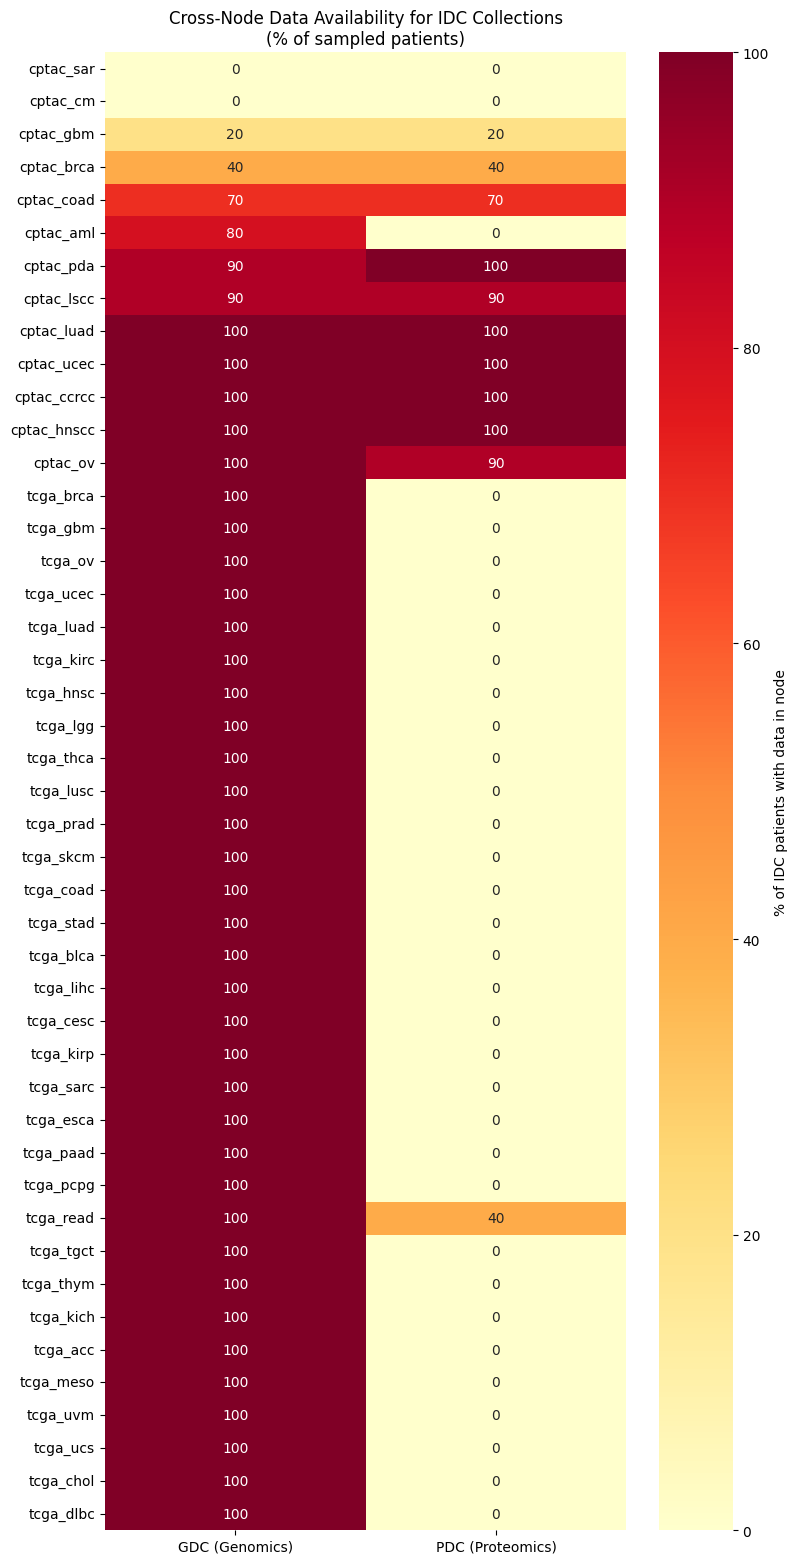

In [6]:
# Heatmap: collections vs CRDC nodes
heatmap_data = cross_node_df.set_index('collection_id')[['pct_GDC', 'pct_PDC']]
heatmap_data.columns = ['GDC (Genomics)', 'PDC (Proteomics)']

# Sort by GDC percentage descending
heatmap_data = heatmap_data.sort_values('GDC (Genomics)', ascending=True)

fig, ax = plt.subplots(figsize=(8, max(6, len(heatmap_data) * 0.35)))
sns.heatmap(
    heatmap_data, annot=True, fmt='.0f', cmap='YlOrRd',
    vmin=0, vmax=100, ax=ax,
    cbar_kws={'label': '% of IDC patients with data in node'}
)
ax.set_title('Cross-Node Data Availability for IDC Collections\n(% of sampled patients)')
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig(data_dir / 'cross_node_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

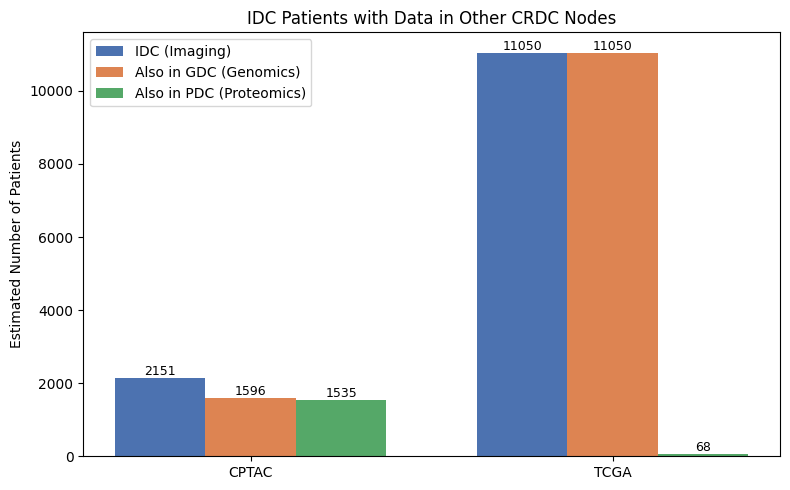

In [7]:
# Bar chart: estimated total patients with cross-node data
cross_node_df['est_with_GDC'] = (cross_node_df['pct_GDC'] / 100 * cross_node_df['idc_patients']).round().astype(int)
cross_node_df['est_with_PDC'] = (cross_node_df['pct_PDC'] / 100 * cross_node_df['idc_patients']).round().astype(int)

by_program = cross_node_df.groupby('program').agg(
    idc_patients=('idc_patients', 'sum'),
    est_with_GDC=('est_with_GDC', 'sum'),
    est_with_PDC=('est_with_PDC', 'sum')
)

fig, ax = plt.subplots(figsize=(8, 5))
x = range(len(by_program))
width = 0.25

bars1 = ax.bar([i - width for i in x], by_program['idc_patients'], width, label='IDC (Imaging)', color='#4C72B0')
bars2 = ax.bar(x, by_program['est_with_GDC'], width, label='Also in GDC (Genomics)', color='#DD8452')
bars3 = ax.bar([i + width for i in x], by_program['est_with_PDC'], width, label='Also in PDC (Proteomics)', color='#55A868')

ax.set_xticks(x)
ax.set_xticklabels(by_program.index)
ax.set_ylabel('Estimated Number of Patients')
ax.set_title('IDC Patients with Data in Other CRDC Nodes')
ax.legend()

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}',
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(data_dir / 'cross_node_bars.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Deep Dive: File Categories Available per Node

For a representative TCGA and CPTAC subject with full cross-node data, examine what file types are available.

In [8]:
def get_file_breakdown(patient_id):
    """Get file category breakdown by data source for a patient."""
    subject = get_subject_data(match_all=[f'upstream_id = {patient_id}'])
    if len(subject) == 0:
        return None
    
    sid = subject['subject_id'].iloc[0]
    files = get_file_data(match_all=[f'subject_id = {sid}'])
    
    if len(files) == 0:
        return None
    
    exploded = files.explode('data_source')
    breakdown = exploded.groupby(['data_source', 'category']).agg(
        files=('file_id', 'count'),
        total_size_MB=('size', lambda x: round(x.sum() / 1e6, 1))
    ).reset_index()
    
    return breakdown

In [9]:
# TCGA example — pick a TCGA-LIHC subject
tcga_example = idc.sql_query("""
    SELECT DISTINCT PatientID FROM index
    WHERE collection_id = 'tcga_lihc'
    LIMIT 1
""")
tcga_pid = tcga_example['PatientID'].iloc[0]
print(f"TCGA example: {tcga_pid}")

tcga_files = get_file_breakdown(tcga_pid)
if tcga_files is not None:
    print(f"\nFile breakdown for {tcga_pid}:")
    display(tcga_files)

TCGA example: TCGA-DD-A116



File breakdown for TCGA-DD-A116:


,data_source,category,files,total_size_MB
0,GDC,<NA>,10,0.7
1,GDC,Biospecimen,16,3150.7
2,GDC,Copy Number Variation,14,217.8
3,GDC,DNA Methylation,6,58.7
4,GDC,Proteome Profiling,1,0.0
5,GDC,Sequencing Reads,20,151901.6
6,GDC,Simple Nucleotide Variation,20,77.1
7,GDC,Structural Variation,8,0.0
8,GDC,Transcriptome Profiling,8,13.1
9,IDC,Computed Tomography,10,316.8


In [10]:
# CPTAC example — pick a subject with GDC+PDC+IDC data
cptac_pids = idc.sql_query("""
    SELECT DISTINCT PatientID FROM index
    WHERE collection_id LIKE 'cptac_%'
    ORDER BY PatientID
    LIMIT 20
""")

# Find one with PDC data
for pid in cptac_pids['PatientID']:
    subject = get_subject_data(match_all=[f'upstream_id = {pid}'])
    if len(subject) > 0 and 'PDC' in subject['data_source'].iloc[0]:
        print(f"CPTAC example with PDC data: {pid}")
        print(f"  data_source: {subject['data_source'].iloc[0]}")
        cptac_files = get_file_breakdown(pid)
        if cptac_files is not None:
            print(f"\nFile breakdown for {pid}:")
            display(cptac_files)
        break

CPTAC example with PDC data: 01BR001
  data_source: ['GC', 'GDC', 'IDC', 'PDC']



File breakdown for 01BR001:


,data_source,category,files,total_size_MB
0,GC,<NA>,17,617.1
1,GC,RNA-Seq,9,87.6
2,GC,WGS,2,26.7
3,GC,WXS,8,247.6
4,GC,miRNA-Seq,1,1.0
5,GDC,Sequencing Reads,11,157496.7
6,GDC,Simple Nucleotide Variation,22,25.9
7,GDC,Structural Variation,4,0.0
8,GDC,Transcriptome Profiling,4,7.1
9,IDC,Slide Microscopy,7,1286.4


## 5. Summary

### What data from other CRDC nodes is available for IDC cases?

In [11]:
total_idc = cross_node_df['idc_patients'].sum()
total_gdc = cross_node_df['est_with_GDC'].sum()
total_pdc = cross_node_df['est_with_PDC'].sum()

print("=" * 60)
print("CROSS-NODE DATA AVAILABILITY SUMMARY")
print("=" * 60)
print(f"\nIDC patients in TCGA+CPTAC collections: {total_idc:,}")
print(f"Estimated with GDC (genomic) data:       {total_gdc:,} ({total_gdc/total_idc*100:.0f}%)")
print(f"Estimated with PDC (proteomic) data:     {total_pdc:,} ({total_pdc/total_idc*100:.0f}%)")
print()
print("By program:")
for program in ['TCGA', 'CPTAC']:
    prog_df = cross_node_df[cross_node_df['program'] == program]
    print(f"\n  {program}:")
    print(f"    Collections: {len(prog_df)}")
    print(f"    IDC patients: {prog_df['idc_patients'].sum():,}")
    print(f"    With GDC data: {prog_df['est_with_GDC'].sum():,}")
    print(f"    With PDC data: {prog_df['est_with_PDC'].sum():,}")

print()
print("Data types available from other CRDC nodes:")
print("  GDC: Sequencing reads, copy number variation, DNA methylation,")
print("       transcriptome profiling, somatic mutations, clinical supplements")
print("  PDC: Mass spectrometry proteomics, protein abundance")
print()
print("CDA tables for enrichment: observation (diagnosis/staging),")
print("  treatment, mutation, upstream_identifiers")

CROSS-NODE DATA AVAILABILITY SUMMARY

IDC patients in TCGA+CPTAC collections: 13,201
Estimated with GDC (genomic) data:       12,646 (96%)
Estimated with PDC (proteomic) data:     1,603 (12%)

By program:

  TCGA:
    Collections: 32
    IDC patients: 11,050
    With GDC data: 11,050
    With PDC data: 68

  CPTAC:
    Collections: 13
    IDC patients: 2,151
    With GDC data: 1,596
    With PDC data: 1,535

Data types available from other CRDC nodes:
  GDC: Sequencing reads, copy number variation, DNA methylation,
       transcriptome profiling, somatic mutations, clinical supplements
  PDC: Mass spectrometry proteomics, protein abundance

CDA tables for enrichment: observation (diagnosis/staging),
  treatment, mutation, upstream_identifiers
